In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import math
import copy
from datetime import datetime

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return (d2 - d1).days

def day_index(d):
    return days_between('2004-01-01', d)

In [18]:
query_dict = {}
# Query dict, query_id -> query

with open('./data/US/queries_filtered.txt') as f:
    raw_us_queries = f.read().splitlines()
query_ids_us = set([int(r.split('\t')[0]) for r in raw_us_queries])
query_dict.update({int(r.split('\t')[0]): r.split('\t')[1] for r in raw_us_queries})
q_freq_us_raw = pd.read_csv('./data/US/Q_freq.csv')

with open('./data/England/queries_filtered.txt') as f:
    raw_england_queries = f.read().splitlines()
query_ids_england = set([int(r.split('\t')[0]) for r in raw_england_queries])
query_dict.update({int(r.split('\t')[0]): r.split('\t')[1] for r in raw_england_queries})
q_freq_england_raw = pd.read_csv('./data/England/Q_freq.csv')

In [4]:
def process_query_data(q_freq_raw, query_ids):
    q_freq_raw_filtered  = q_freq_raw[q_freq_raw['Query'].isin(query_ids)]
    # Transform the data so that each row is a day and each column is a query, with the value being the frequency of the query on that day
    q_freq_raw_filtered = q_freq_raw_filtered.pivot(index='Day', columns='Query', values='Frequency')
    # Interpolate missing values with linear interpolation
    q_freq_raw_filtered = q_freq_raw_filtered.interpolate(method='linear', axis=0)
    # Extrapolate so starting days and ending days have values
    q_freq_raw_filtered = q_freq_raw_filtered.bfill()
    # Apply moving average filter
    q_freq_raw_filtered = q_freq_raw_filtered.rolling(window=7, min_periods=1).mean()
    # Min-max normalize the data, grouping by query. Each query is normalized independently.
    # Find the minimum and maximum frequency of each query independently
    query_min = {query: q_freq_raw_filtered[query].min() for query in q_freq_raw_filtered.columns}
    query_max = {query: q_freq_raw_filtered[query].max() for query in q_freq_raw_filtered.columns}
    # Normalize the data
    for query in q_freq_raw_filtered.columns:
        q_freq_raw_filtered[query] = (q_freq_raw_filtered[query] - query_min[query]) / (query_max[query] - query_min[query])
    # Fill NaN values with 0
    q_freq_raw_filtered = q_freq_raw_filtered.fillna(0)
    return q_freq_raw_filtered

q_freq_us_raw_filtered = process_query_data(q_freq_us_raw, query_ids=query_ids_us)
q_freq_england_raw_filtered = process_query_data(q_freq_england_raw, query_ids=query_ids_england)

[2443, 2647, 21761, 1440, 7074, 5531, 765, 474, 3977, 6465]


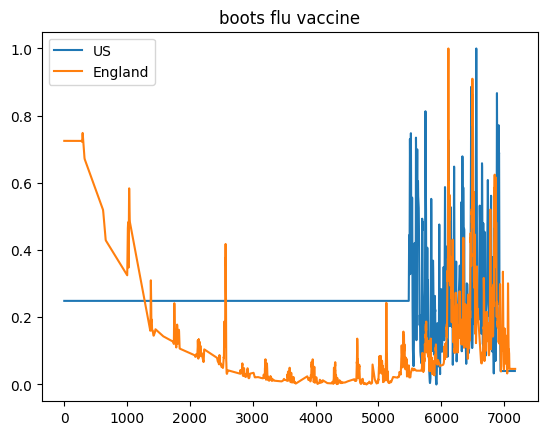

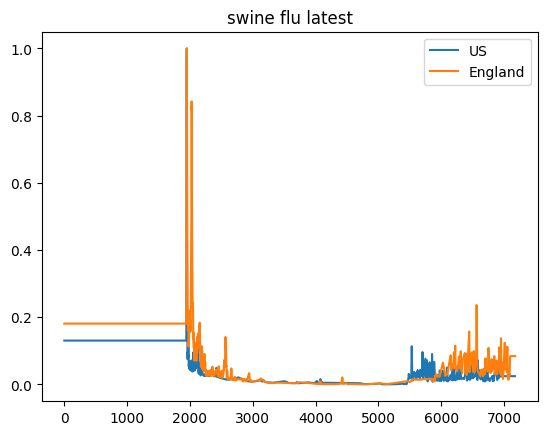

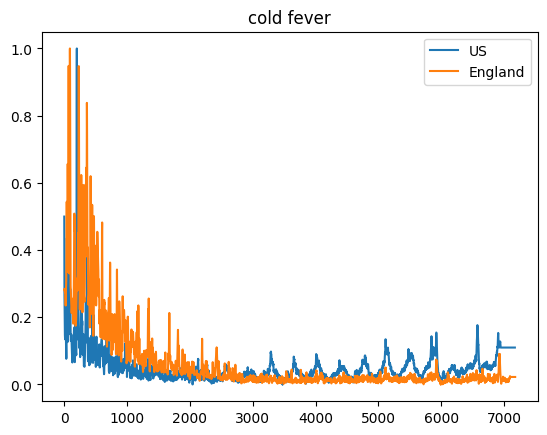

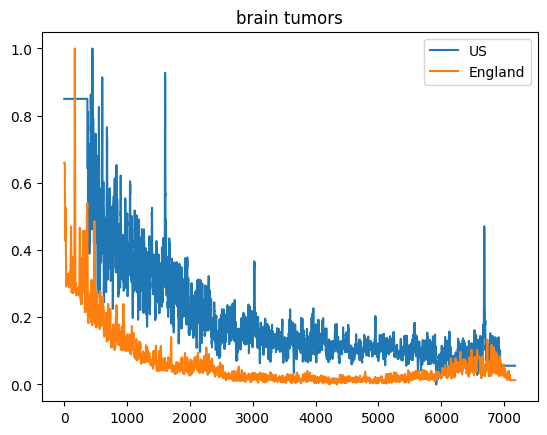

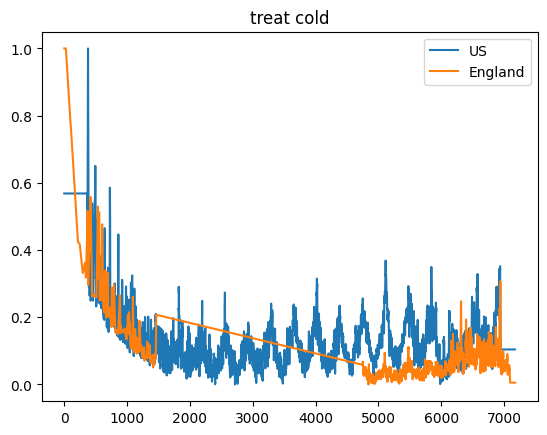

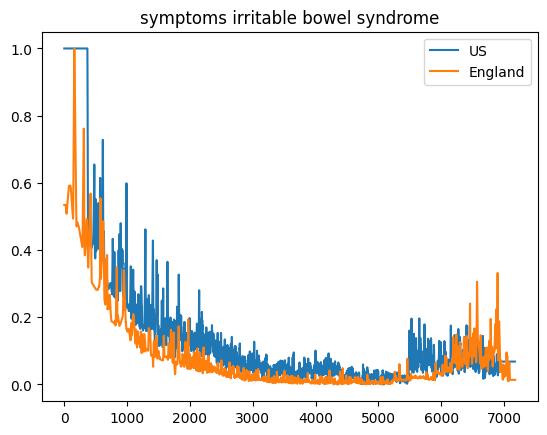

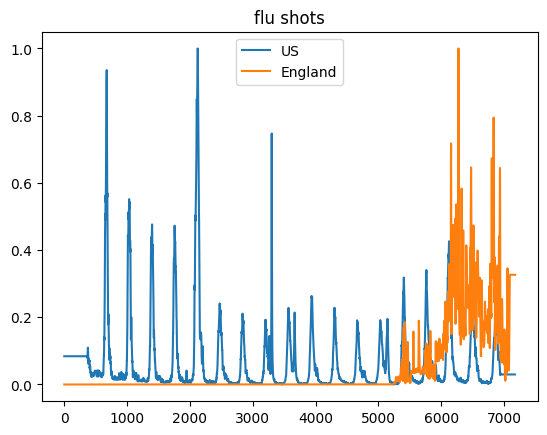

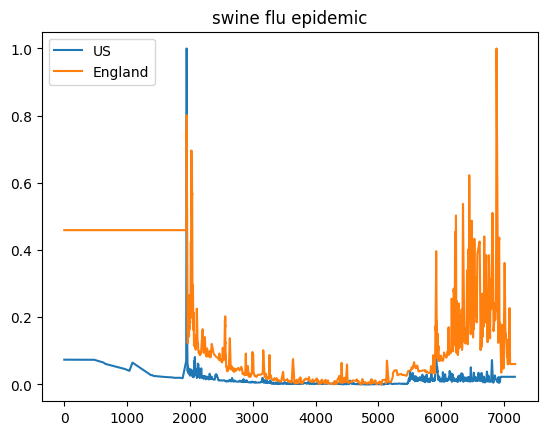

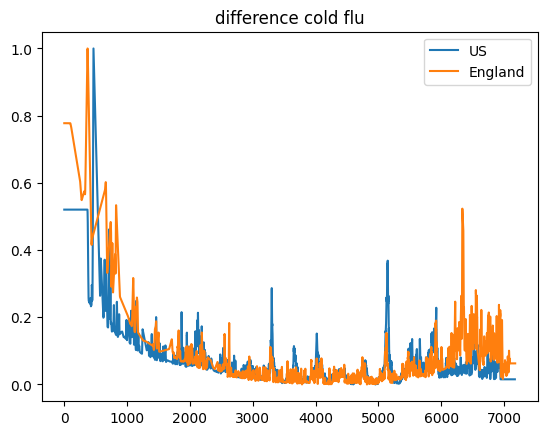

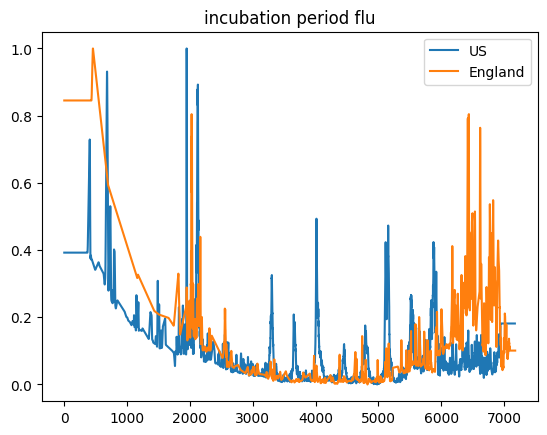

In [20]:
# Randomly select 10 queries, plot them in both US and England (as 10 plots with 2 lines each)
import matplotlib.pyplot as plt
import random

qid_england = q_freq_england_raw_filtered.columns
qid_us = q_freq_us_raw_filtered.columns
intersection_query_ids = set(qid_england).intersection(set(qid_us))

queries = random.sample(sorted(intersection_query_ids), 10)
print(queries)
for query in queries:
    plt.plot(q_freq_us_raw_filtered[query], label='US')
    plt.plot(q_freq_england_raw_filtered[query], label='England')
    plt.title(query_dict[query])
    plt.legend()
    plt.show()